# Heston Model


One of the main limitations of the Merton-Black-Scholes model is its restrictive assumption of constant volatility. The Heston model is a generalization of the BSM model that allows for stochastic volatility. 
The Heston model defines volatility as a mean reverting process, i.e., oscillating around a well-defined long-term average value. 
The spot asset is correlated with its volatility. It does not require that asset returns follow a log-normal distribution. 

## Heston SDEs. 

The stochastic differential equations of the basic Heston model are defined as
$$ dS_t = \mu S_t dt + \sqrt{v_t}S_t dW_t^S $$
$$ dv_t = \kappa (\theta - v_t)dt + \sigma \sqrt{v_t}S_t dW_t^v $$
where $W_t^S, W_t^v$ are Weiner processes with correlation $\rho$, $\kappa$ is the mean reversion speed for the variance $v_t$, $\theta$ is the mean reversion level, and $\sigma$ is the volatility of volatility. 

## Simulating Heston Paths with Python.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

In [3]:
def heston_sim(S0=100, v0=0.25**2, rho=0.98, kappa=3, theta=0.2**2, sigma=0.6,  r=0.02, T=1.0, M=252, n=1000):
    """
    Args: 
        S0 (float):     initial spot stock price of the underlying instrument. 
        v0 (float):     initial variance of the underlying instrument. 
        rho (float):    correlation between asset returns and variance. 
        kappa (float):  rate of mean reversion in variance process. 
        theta (float):  long-term mean of variance process
        sigma (float):  volatility of variance process. 
        r (float):      the risk-free rate. 
        T (float):      time of simulation.
        M (int):        number of simulations
        n (int):        number of time steps.
    Returns:
        S (list):       prices at timesteps
        v (list):       volatility at timesteps
    """
    dt = T/M
    S = np.zeros((M, n))
    v = np.zeros((M, n))
    S_t = S0
    v_t = v0
    Z = np.random.multivariate_normal(np.array([0,0]), 
                                      cov = np.array([[1,rho],
                                                     [rho,1]]), 
                                      size=(M,n)) * np.sqrt(dt)
    for t in range(n):
        S_t = S_t * (np.exp((r-0.5*v_t)*dt + np.sqrt(v_t)*Z[:,t,0])) 
        v_t = np.abs(v_t + kappa*(theta-v_t)*dt + sigma*np.sqrt(v_t)*Z[:,t,1])
        S[:, t] = S_t
        v[:, t] = v_t
    return S, v

Below are some parameters used in simulating Heston paths. In practice, they would be estimated from market data. 

In [13]:
S0 = 100        # intial price
v0 = 0.02       # initial variance
kappa = 4       # rate of mean-reversion in variance process
theta = 0.02    # long-term mean of variance process
sigma = 0.9     # volatility of variance process
r = 0.02        # riskfree rate
n = 500         # num time steps
M = 200         # num simulations
T = 1           # time of simulation

S, v = heston_sim(S0=S0, 
                  v0=v0, 
                  rho=0.7, 
                  kappa=kappa, 
                  theta=theta, 
                  sigma=sigma, 
                  T=T, 
                  M=M, 
                  n=n, 
                  r=r)

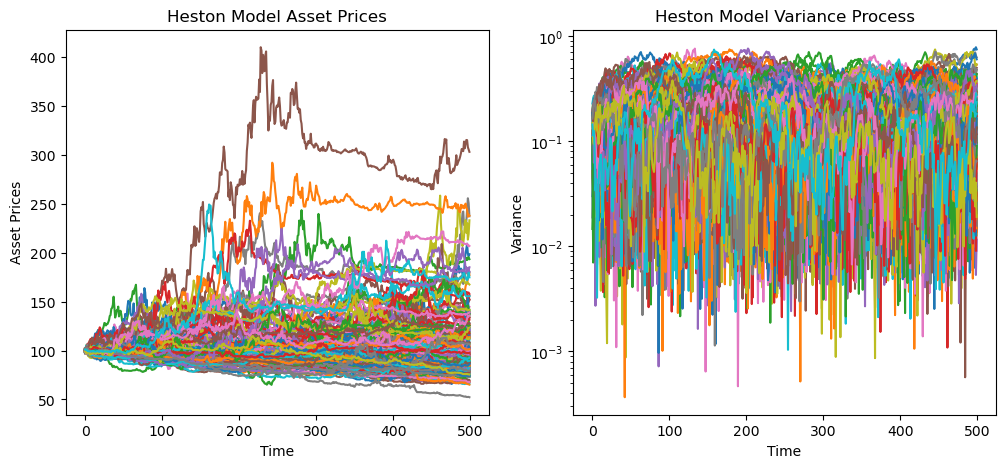

In [15]:
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(12,5))
ax1.plot(S.T)
ax1.set_title('Heston Model Asset Prices')
ax1.set_xlabel('Time')
ax1.set_ylabel('Asset Prices')
plt.yscale("log")#
ax2.plot(np.sqrt(v).T)
ax2.set_title('Heston Model Variance Process')
ax2.set_xlabel('Time')
ax2.set_ylabel('Variance')
plt.show()

## Heston Density.

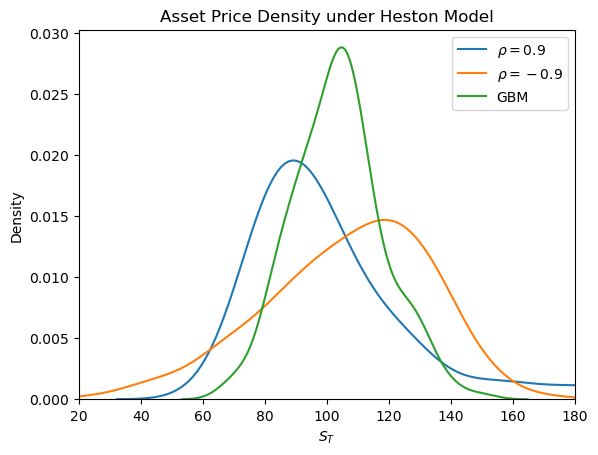

In [89]:
geometric_brownian_motion = S0*np.exp( np.random.normal((r - v0/2)*T , np.sqrt(theta)*np.sqrt(T), size=M))
S_1, _ = heston_sim(S0=S0, v0=v0, rho=0.9, kappa=kappa, theta=theta, sigma=sigma, T=T, M=M, n=n, r=r)
S_2, _ = heston_sim(S0=S0, v0=v0, rho=-0.9, kappa=kappa, theta=theta, sigma=sigma, T=T, M=M, n=n, r=r)
fig, ax = plt.subplots()
ax = sns.kdeplot(S_1.T[-1], label=r"$\rho= 0.9$", ax=ax)
ax = sns.kdeplot(S_2.T[-1], label=r"$\rho= -0.9$", ax=ax)
ax = sns.kdeplot(geometric_brownian_motion, label="GBM", ax=ax)
plt.title(r'Asset Price Density under Heston Model')
plt.xlim([20, 180])
plt.xlabel('$S_T$')
plt.ylabel('Density')
plt.legend()
plt.show()

## Volatility Smile. 

Volatility smiles are implied volatility patterns that arise in option pricing. 
The pattern is a result of deep in-the-money or out-of-the-money options commanding higher prices than what is suggested by the constant volatility BSM model. 
One reason for this might be that 'Black Swan' events are observed far more frequently than what a Gaussian distribution of market returns model would suggest. 
Since the Heston model is a stochastic volatility model, we expect to observe the volatility smile pattern in options priced using Heston paths. 


To observe the volatility smile pattern, we must first define a function for calculating the implied volatility of vanilla European options. 

In [90]:
from scipy.stats import norm
from scipy.optimize import minimize_scalar   
N = norm.cdf

def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*N(-d2) - S*N(-d1)    
    

def implied_vol(opt_value, S, K, T, r, type_='call'):
    
    def call_obj(sigma):
        return abs(BS_CALL(S, K, T, r, sigma) - opt_value)
    
    def put_obj(sigma):
        return abs(BS_PUT(S, K, T, r, sigma) - opt_value)
    
    if type_ == 'call':
        res = minimize_scalar(call_obj, bounds=(0.01,6), method='bounded')
        return res.x
    elif type_ == 'put':
        res = minimize_scalar(put_obj, bounds=(0.01,6),
                              method='bounded')
        return res.x
    else:
        raise ValueError("type_ must be 'put' or 'call'")
        

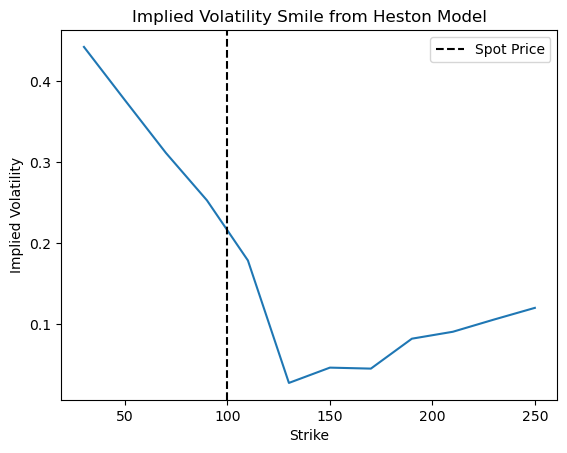

In [91]:
strikes =np.arange(30,251,20)
puts = [np.mean(np.maximum(K-S_2[:,-1],0))*np.exp(-r*T) for K in strikes]
ivs = [implied_vol(P, S0, K, T, r, type_ = 'put' ) for P, K in zip(puts,strikes)]

plt.plot(strikes, ivs)
plt.ylabel('Implied Volatility')
plt.xlabel('Strike')
plt.axvline(S0, color='black',linestyle='--',label='Spot Price')
plt.title('Implied Volatility Smile from Heston Model')
plt.legend()
plt.show()

## Barrier Options. 

Barrier options are call and put options that are path-dependent and come into existence ("knock-in") or become worthless ("knock-out") based on a condition linked to the performance of the underlying.
Knock-in options expire worthless unless a lower barrier $B$ is triggered, in which case it becomes a vanilla option. Knock-out options expire worthless unless an upper barrier $B$ is triggered, in which case it also becomes a vanilla option. 
Barrier options has the typical payoffs $\max{\{ Price-Strike, 0 \}}$ and $\max{\{ Strike-Price, 0 \}}$ for calls and puts respectively. Additionally, the payoff is multiplied with an indicator function $\mathbb{1}_{condition}$ defined by some condition. 
The four main types of barrier options and their condition are as follows
1. Up & Out: $\max_{t \in [0,T]}{S_t < B}$. I.e., the option expires worthless if the price of the underlying reaches some upper barrier $B$, else it is a vanilla option. 
2. Up & In: $\max_{t \in [0,T]}{S_t \geq B} $. I.e., the option expires worthless if the price of the underlying never reaches some upper barrier $B$, else it is a vanilla option. 
3. Down & Out: $\min_{t \in [0,T]}{S_t > B} $. I.e., the option expires worthless if the price of the underlying reaches some lower barrier $B$, else it is a vanilla option. 
4. Down & In: $\min_{t \in [0,T]}{S_t \leq B}$. I.e., the option expires worthless if the price of the underlying never reaches some lower barrier $B$, else it is a vanilla option. 


In [72]:
class Option():
    def __init__(self, strike: float, call=True):
        self.strike = strike
        self.call = call
    
    def payoff(self, price_of_underlying):
        if self.call:
            return np.maximum(0, price_of_underlying - self.strike)
        else:
            return np.maximum(0, self.strike - price_of_underlying)


class BarrierOption(Option):
    def __init__(self, strike: float, barrier: float, call=True, condition=False):
        super().__init__(strike=strike, call=call)
        self.barrier = barrier
        self.condition = condition
        self.initial_condition = condition

    def payoff(self, price_of_underlying):
        if self.condition == self.initial_condition:
            self.condition = self.barrier_condition(price_of_underlying=price_of_underlying)
        return super().payoff(price_of_underlying=price_of_underlying)*self.condition


class UpAndIn(BarrierOption): 
    def __init__(self, strike: float, barrier: float, call=True):
        super().__init__(strike=strike, barrier=barrier, call=call, condition=False)

    def barrier_condition(self, price_of_underlying):
        return (price_of_underlying >= self.barrier)


class UpAndOut(BarrierOption): 
    def __init__(self, strike: float, barrier: float, call=True):
        super().__init__(strike=strike, barrier=barrier, call=call, condition=True)

    def barrier_condition(self, price_of_underlying):
        return (price_of_underlying < self.barrier)


class DownAndIn(BarrierOption): 
    def __init__(self, strike: float, barrier: float, call=True):
        super().__init__(strike=strike, barrier=barrier, call=call, condition=False)

    def barrier_condition(self, price_of_underlying):
        return (price_of_underlying <= self.barrier)


class DownAndOut(BarrierOption): 
    def __init__(self, strike: float, barrier: float, call=True):
        super().__init__(strike=strike, barrier=barrier, call=call, condition=True)

    def barrier_condition(self, price_of_underlying):
        return (price_of_underlying > self.barrier)


Below is an example of an up and in barrier put option where we display the payoff at different prices of the underlying. 

In [73]:
strike = 100
barrier = 120
option = UpAndIn(strike=strike, barrier=barrier, call=False)

An up and in put option starts out worthless and becomes a vanilla option once the upper barrier is triggered.

In [74]:
print("Payoff for a up and in put option with strike ", strike, " and barrier ", barrier)
print("Payoff for underlying price 60: ", option.payoff(price_of_underlying=60)) 
print("Payoff for underlying price 100: ", option.payoff(price_of_underlying=100)) 

Payoff for a up and in put option with strike  100  and barrier  120
Payoff for underlying price 60:  0
Payoff for underlying price 100:  0


Since the barrier has not been triggered, the options are worthless as expected. Now we trigger the barrier.

In [75]:
print("Payoff for underlying price 120: ", option.payoff(price_of_underlying=120)) 

Payoff for underlying price 120:  0


Now we go back to the previous examples and see that the payoff has changed now that the barrier has been triggered. 

In [76]:
print("Payoff for underlying price 60: ", option.payoff(price_of_underlying=60)) 
print("Payoff for underlying price 100: ", option.payoff(price_of_underlying=100)) 

Payoff for underlying price 60:  40
Payoff for underlying price 100:  0


Further, we can verify that the other barrier options produce the expected payoffs. 

In [77]:
strike = 100
barrier = 120
option = UpAndOut(strike=strike, barrier=barrier, call=True)

print("Payoff for a up and in put option with strike ", strike, " and barrier ", barrier)
print("Payoff for underlying price 60: ", option.payoff(price_of_underlying=60)) 
print("Payoff for underlying price 110: ", option.payoff(price_of_underlying=110))

print("Payoff for underlying price 120: ", option.payoff(price_of_underlying=120)) 

print("Payoff for underlying price 60: ", option.payoff(price_of_underlying=60)) 
print("Payoff for underlying price 110: ", option.payoff(price_of_underlying=110)) 


Payoff for a up and in put option with strike  100  and barrier  120
Payoff for underlying price 60:  0
Payoff for underlying price 110:  10
Payoff for underlying price 120:  0
Payoff for underlying price 60:  0
Payoff for underlying price 110:  0


In [78]:
strike = 100
barrier = 80
option = DownAndIn(strike=strike, barrier=barrier, call=False)

print("Payoff for a up and in put option with strike ", strike, " and barrier ", barrier)
print("Payoff for underlying price 90: ", option.payoff(price_of_underlying=90)) 
print("Payoff for underlying price 110: ", option.payoff(price_of_underlying=110)) 

print("Payoff for underlying price 80: ", option.payoff(price_of_underlying=80)) 

print("Payoff for underlying price 90: ", option.payoff(price_of_underlying=90)) 
print("Payoff for underlying price 110: ", option.payoff(price_of_underlying=110)) 


Payoff for a up and in put option with strike  100  and barrier  80
Payoff for underlying price 90:  0
Payoff for underlying price 110:  0
Payoff for underlying price 80:  20
Payoff for underlying price 90:  10
Payoff for underlying price 110:  0


In [79]:
strike = 100
barrier = 80
option = DownAndOut(strike=strike, barrier=barrier, call=True)

print("Payoff for a up and in put option with strike ", strike, " and barrier ", barrier)
print("Payoff for underlying price 90: ", option.payoff(price_of_underlying=90)) 
print("Payoff for underlying price 110: ", option.payoff(price_of_underlying=110)) 

print("Payoff for underlying price 80: ", option.payoff(price_of_underlying=80)) 

print("Payoff for underlying price 90: ", option.payoff(price_of_underlying=90)) 
print("Payoff for underlying price 110: ", option.payoff(price_of_underlying=110)) 


Payoff for a up and in put option with strike  100  and barrier  80
Payoff for underlying price 90:  0
Payoff for underlying price 110:  10
Payoff for underlying price 80:  0
Payoff for underlying price 90:  0
Payoff for underlying price 110:  0


## Pricing (Barrier) Options with the Heston Model. 

We use Monte Carlo methods that sample Heston paths as simulations of a stochastic volatility financial asset and use those paths to approximate the value of an option. In this example, we use one of the barrier options defined above. 


We start with generating Heston paths. 
A copy of the option is created for every path. 
It is important to remember to trigger the barrier before calculating the value of the option. Therefore, the highest and lowest value of each path is registered for each unique copy of the option, before the last value is used to calculate the option value. 



In [80]:
def heston_paths_monte_carlo(option, S0=100, v0=0.25**2, rho=0.98, kappa=3, theta=0.2**2, sigma=0.6,  r=0.02, T=1.0, M=200, n=500):
    S, _ = heston_sim(S0=S0, v0=v0, rho=rho, kappa=kappa, theta=theta, sigma=sigma, T=T, M=M, n=n, r=r)    
    individual_options = [deepcopy(option) for _ in range(n)]
    relevant_prices_for_barrier_options = np.concatenate(([np.amin(S, axis=1)], [np.amax(S, axis=1)], [S[:,-1]])).T
    payoff = np.array([[io.payoff(price_of_underlying=p) for p in SS] for io, SS in zip(individual_options, relevant_prices_for_barrier_options)])
    payoff = np.mean(np.exp(-r*T) * payoff[:,-1])
    return payoff

Below are plots of the approximated value of the up-and-out barrier call option with fixed barrier and variable strike, and fixed strike and variable barrier. 
As expected, when the barrier of an up-and-out call option increases, its value converges to a vanilla call option. 

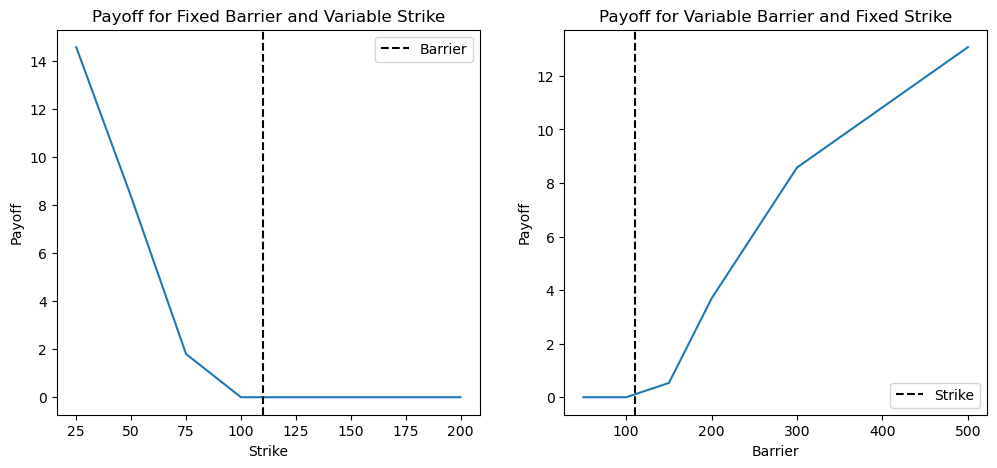

In [81]:
strike_strike_change = np.arange(25, 201, 25)
barrier_strike_change = 110
payoffs_strike_change = np.array([heston_paths_monte_carlo(UpAndOut(strike=s, barrier=barrier_strike_change, call=True), M=M, n=n) for s in strike_strike_change])

strike_barrier_change = 110
barrier_barrier_change = [50, 75, 100, 150, 200, 300, 500]
payoffs_barrier_change = np.array([heston_paths_monte_carlo(UpAndOut(strike=strike_barrier_change, barrier=b, call=True), M=M, n=n) for b in barrier_barrier_change])

fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(12,5))
ax1.plot(strike_strike_change, payoffs_strike_change)
ax1.set_title('Payoff for Fixed Barrier and Variable Strike')
ax1.set_xlabel('Strike')
ax1.set_ylabel('Payoff')
ax1.axvline(barrier_strike_change, color='black',linestyle='--',label='Barrier')
ax1.legend()
ax2.plot(barrier_barrier_change, payoffs_barrier_change)
ax2.set_title('Payoff for Variable Barrier and Fixed Strike')
ax2.set_xlabel('Barrier')
ax2.set_ylabel('Payoff')
ax2.axvline(strike_barrier_change, color='black',linestyle='--',label='Strike')
ax2.legend()
plt.show()
